# 概要
このノートブックでは, 最適化問題用のライブラリcvxoptを用いて

各種SVMを実装し, 比較を行う.

In [1]:
import cvxopt
from cvxopt import matrix
import numpy as np
from sklearn.metrics.pairwise import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#データの生成
np.random.seed(0)
data1 = np.random.randn(100, 2)+np.array([2,4])
data2 = np.random.randn(100, 2)+np.array([4,2])
data = np.r_[data1, data2]
y = np.r_[np.ones(100), (-1)*np.ones(100)]

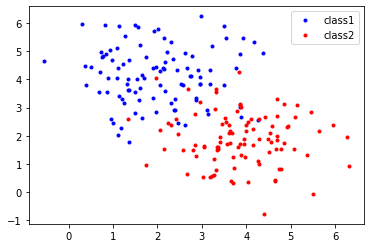

In [3]:
#データ分布の可視化
plt.figure()
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

## L1-SVM (線形)
-------------------------------------------
**最適化問題**

L1-SVMは次の最適化問題で定義される.


\begin{align}
\mathrm{min}\quad &\frac{1}{2} \| \boldsymbol{w} \|^2+C \sum_{i=1}^M \xi_i \\
\mathrm{s.t} \quad &y_i D(\boldsymbol{x}_i ) \geq 1- \xi_i,\quad \xi_i \geq 0
\end{align}


ただし,
SVMの決定関数$D(\boldsymbol{x}_i)$は


\begin{align}
D(\boldsymbol{x}) = \boldsymbol{w}^\top \boldsymbol{x}+b
\end{align}


である.


この最適化問題にラグランジュ未定乗数$\alpha_i (i=1, \cdots, M)$を導入すると,


\begin{align}
\mathrm{max}\quad &\sum_{i=1}^M \alpha_i - \frac{1}{2} \sum_{i, j=1}^M \alpha_i \alpha_j y_i y_j \boldsymbol{x}_i^\top \boldsymbol{x}_j \\
\mathrm{s.t.} \quad &\sum_{i=1}^M \alpha_i y_i = 0,\quad 0 \leq \alpha_i \leq C 
\end{align}

ここで, $\boldsymbol{w} = \sum_{i \in SV} \alpha_i y_i \boldsymbol{x}_i$である.

---------------------------------------------------------


**SVについて**

$\alpha_i=0$に対応する$x_i$は正しく識別できている教師データ(非SV)

$0<\alpha_i<C$に対応する$x_i$は上限に達していないサポートベクトル ($D(x) = \pm 1$上)

$\alpha_i=C$に対応する$x_i$は上限に達したサポートベクトル

----------------------------------------------------

**cvxoptについて**

cvxoptのqpは以下の最適化問題を解く.

\begin{align}
\mathrm{min}\quad &\frac{1}{2} \boldsymbol{\alpha}^\top P \boldsymbol{\alpha} -\boldsymbol{q}^\top \boldsymbol{\alpha}\\
\mathrm{s.t.} \quad &A\boldsymbol{\alpha} = \boldsymbol{b}, \quad G\boldsymbol{\alpha} \leq \boldsymbol{h} 
\end{align}

-----------------------------------------------------

In [4]:
class L1SVM(object):
    def __init__(self, C=10):
        self.C = C
        cvxopt.solvers.options['abstol']=1e-15
        cvxopt.solvers.options['reltol']=1e-15
        cvxopt.solvers.options['feastol']=1e-15
        cvxopt.solvers.options['maxiters']=500
        
    def fit(self, train_X, train_Y):
        #内積行列を作成
        K = train_X @ train_X.T
        
        #cvxopt用の変数
        P = matrix(K*train_Y.reshape(1,-1)*train_Y.reshape(-1,1), K.shape ,'d')
        q = matrix((-1)*np.ones(K.shape[0]).reshape(-1,1),(K.shape[0],1) ,'d')
        A = matrix(train_Y.reshape(1,-1),(1,K.shape[0]),'d')
        b = matrix(np.array([0]),(1,1),'d')
        G1 = (-1)*np.identity(K.shape[0])
        h1 = np.zeros(K.shape[0]).reshape(-1,1)
        G2 = np.identity(K.shape[0])
        h2 = self.C*np.ones(K.shape[0]).reshape(-1,1)
        
        G = matrix(np.r_[G1, G2],(2*K.shape[0], K.shape[0]), 'd')
        h = matrix(np.r_[h1, h2],(2*K.shape[0],1),'d')

        self.sol = cvxopt.solvers.qp(P=P, q=q, A=A, b=b, G=G, h=h)
        self.alpha = np.array(self.sol['x']).reshape(-1)
        if(self.C > 1):
            idx = np.where(self.alpha<1e-3)
        else:
            idx = np.where(self.alph<self.C*1e-4)
        self.alpha[idx] = 0
        self.sv_index = np.where(self.alpha>0)
        self.sv = train_X[self.sv_index]
        self.sv_label = train_Y[self.sv_index]
        self.w = np.sum([self.alpha[i]*train_Y[i]*train_X[i] for i in range(len(train_Y))], axis=0)
        self.b = np.sum([self.sv_label[i]-self.w.reshape(1,-1) @ self.sv[i].T for i in range(len(self.sv_label))])/len(self.sv_label)
        
    def decision_function(self,X):
        return X @ self.w.reshape(-1,1) +np.ones((X.shape[0],1))*self.b
    
    def predict(self, X):
        D = self.decision_function(X)
        predict_y = np.ones(X.shape[0])
        predict_y[D.reshape(-1)<0]=-1
        return predict_y
    
    def score(self, X, Y):
        predict_y = self.predict(X)
        return 100*np.sum(Y==predict_y)/len(Y)

In [5]:
#学習
l1svm = L1SVM(C=10)
l1svm.fit(data, y)
print(f'score : {l1svm.score(data,y)}%')

     pcost       dcost       gap    pres   dres
 0: -3.4241e+02 -1.5013e+04  4e+04  8e-01  6e-13
 1: -2.4118e+02 -4.3551e+03  6e+03  6e-02  5e-13
 2: -2.4102e+02 -9.3656e+02  8e+02  7e-03  4e-13
 3: -2.9332e+02 -5.5723e+02  3e+02  2e-03  4e-13
 4: -2.9745e+02 -5.1075e+02  2e+02  1e-03  4e-13
 5: -3.1346e+02 -5.0754e+02  2e+02  8e-04  4e-13
 6: -3.3007e+02 -4.4283e+02  1e+02  4e-04  4e-13
 7: -3.4090e+02 -4.1993e+02  8e+01  2e-04  4e-13
 8: -3.5207e+02 -3.8857e+02  4e+01  2e-16  5e-13
 9: -3.6073e+02 -3.7536e+02  1e+01  6e-14  5e-13
10: -3.6434e+02 -3.6925e+02  5e+00  1e-15  5e-13
11: -3.6570e+02 -3.6727e+02  2e+00  2e-13  6e-13
12: -3.6643e+02 -3.6645e+02  2e-02  3e-13  5e-13
13: -3.6644e+02 -3.6644e+02  2e-04  3e-13  6e-13
14: -3.6644e+02 -3.6644e+02  2e-06  3e-13  6e-13
15: -3.6644e+02 -3.6644e+02  2e-08  2e-13  6e-13
16: -3.6644e+02 -3.6644e+02  2e-10  5e-14  6e-13
17: -3.6644e+02 -3.6644e+02  2e-12  1e-13  6e-13
Terminated (singular KKT matrix).
score : 92.0%


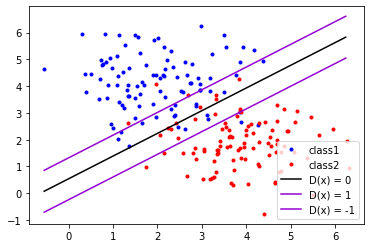

In [6]:
#データ分布の可視化
t = np.linspace(start=min(data[:,0]), stop = max(data[:,1]), num=50)
plt.figure()
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.plot(t, (0-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'black',label='D(x) = 0')
plt.plot(t, (1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = 1')
plt.plot(t, (-1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = -1')
plt.legend()
plt.show()
plt.close()

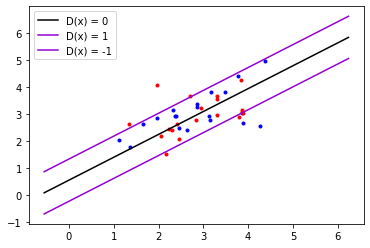

In [7]:
#サポートベクトルの可視化
t = np.linspace(start=min(data[:,0]), stop = max(data[:,1]), num=50)
plt.figure()
idx1 = np.where(l1svm.sv_label==1)
idx2 = np.where(l1svm.sv_label==-1)
plt.plot(l1svm.sv[idx1, 0], l1svm.sv[idx1, 1], 'b.')
plt.plot(l1svm.sv[idx2, 0], l1svm.sv[idx2, 1], 'r.')
plt.plot(t, (0-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'black',label='D(x) = 0')
plt.plot(t, (1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = 1')
plt.plot(t, (-1-l1svm.b-l1svm.w[0]*t)/l1svm.w[1], 'darkviolet',label='D(x) = -1')
plt.legend()
plt.show()
plt.close()

計算の誤差のせいで上限に達していないSVが$D=\pm 1$にピッタリ乗っていないみたいです